# Building a Neural Network from Scratch with NumPy

In [1]:
import random
import time

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.RandomState(seed=0)

RandomState(MT19937) at 0x7F8AA8FD9240

## Single Perceptron

In [4]:
class Perceptron(object):
    def __init__(self, weight, bias):
        self.weight = weight
        self.bias = bias
    
    def feedforward(self, a):
        return self.weight * a + self.bias

In [5]:
p = Perceptron(3, 10)
p.feedforward(5)

25

## Single Sigmoid Neuron

In [6]:
def sigmoid(z):
    a = 1 / (1 + np.exp(-z))
    return a

In [7]:
class SigmoidNeuron(object):
    def __init__(self, weight, bias):
        self.weight = weight
        self.bias = bias
    
    def feedforward(self, a):
        z = self.weight * a + self.bias
        return sigmoid(z)

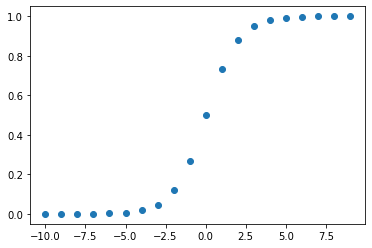

In [8]:
s = SigmoidNeuron(1, 0)

S = []
for i in range(-10, 10):
    S.append(s.feedforward(i))
    
plt.scatter(x = range(-10, 10), y = S)

## Simple Neural Network Feedforward

In [9]:
class SimpleNetwork(object):
    def __init__(self, shapes):
        self.n_layers = len(shapes)
        self.shapes = shapes
        
        # initialise weights and biases randomly
        self.weights = [np.random.randn(n_neuron, previous_n_neuron) for previous_n_neuron, n_neuron in zip(shapes[:-1], shapes[1:])]
        self.biases = [np.random.randn(n_neuron, 1) for n_neuron in shapes[1:]]
    
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, a) + b
            a = sigmoid(z)
        return a

### Initialising a simple neural network

In [10]:
shapes = [5, 3, 2, 1]
sn = SimpleNetwork(shapes)

print("The simple network has {} layers.".format(sn.n_layers), end = '\n\n')
print("The network's weights matrix by layer: \n" + 
            "\n".join("{}".format(w) for w in sn.weights), end = '\n\n')
print("The network's biases matrix by layer: \n" + 
            "\n".join("{}".format(b) for b in sn.biases) )

The simple network has 4 layers.

The network's weights matrix by layer: 
[[ 0.1559758  -2.66305518 -1.00570795 -0.42602583  0.46012749]
 [-1.15567296  1.90801973  0.34407196  0.79525217 -0.45996502]
 [ 2.59702135  0.44643404 -0.39287863 -0.45136611 -1.7771134 ]]
[[-0.59971018 -0.81899182  0.53324852]
 [ 1.81821855  0.29907565  1.12815928]]
[[-0.37786207 -0.71601265]]

The network's biases matrix by layer: 
[[-0.77199394]
 [-1.20410351]
 [-1.2439718 ]]
[[0.19968399]
 [0.50398797]]
[[-0.13471059]]


There should be 3 matrices for each of weights and biases, as each non-input layer has a weight and bias matrix.  

The weight matrix of a non-input layer is of shape __(j x k)__, where:  
__j__ = number of nodes in this _current_ layer (start at non-input layer)  
__k__ = number of nodes in the _previous_ layer (end at non-output layer)  

This in turn agrees with our notation for a specific weight variable, __$w^l_jk$__ , connecting the kth neuron from the previous layer to the jth neuron in the current layer.

### Feedforward

In [11]:
x = np.array([[32], [12], [11], [88], [47]]) # 5x1 input

sn.feedforward(x)

array([[0.318334]])

## Backpropagation Algorithm

The aim of the neural network is to minimise the difference bettween desired and actual prediction from a given set of inputs. This difference is measured using a cost function, and it can be shown that the discrepency of the data is directly proportional to the error, by using chain-rule.
- The backpropagation algorithm is for calculating partial derivatives of Cost with respect to weights, biases and weighted activation (aka the error). 
- The error is defined as __partial derivative of cost, C,  with respect to the weighted activation, z__.
- We assume using the quadratic cost function here, where $C = \frac{1}{2n} \sum_x (y(x) - a)^2$.

### A brief reminder of the four equations used

1. Error in the output layer  
    $\delta ^L = \nabla _a C \odot \sigma ' (z^L)$
1. Error of previous layer in terms of current layer (computing backward)  
    $\delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma ' (z^l)$
1. Rate of change of cost with respect to bias, in terms of error  
    $\frac{\partial C}{\partial b^l_j} = \delta^l_j$
1. Rate of change of cost with respect to weight, in terms of error  
    $\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j$
   
__*note that in the code, error is named 'delta', as this is the Greek letter used to represent error__

In [12]:
def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

# this is the partial derivative of cost w.r.t. output activation, assuming quadratic cost function is used
def cost_derivative(output_activations, y): 
    return (output_activations - y)

In [13]:
# we inherit the SimpleNetwork class and add the backpropagation algorithm
class Network(SimpleNetwork):
    def backprop(self, x, y):
        # create empty arrays for storing the partial derivatives 
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # first, gather each neuron's weighted activation and activation by layer
        a = x
        A = [x]
        Z = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, a) + b
            Z.append(z)
            a = sigmoid(z)
            A.append(a)
        # uncomment to see the weighted activation and activation matrices
        # print("Weighted activations for each non-input layer are: \n" + 
        #              "\n".join("{}".format(z) for z in Z), end = '\n\n')
        # print("Activations for each non-input layer are: \n" + 
        #              "\n".join("{}".format(a) for a in A), end = '\n\n')
        
        # now computes the error for each neuron, by layer in reversing order
        delta = cost_derivative(A[-1], y) * sigmoid_prime(Z[-1]) # equation 1 ('*' operation is Hadamard product)
        nabla_b[-1] = delta # equation 3
        nabla_w[-1] = np.dot(delta, A[-2].transpose()) # equation 4
        
        for i in range(2, self.n_layers):
            z = Z[-i]
            delta = np.dot(self.weights[-i+1].transpose(), delta) * sigmoid_prime(z) # equation 2
            nabla_b[-i] = delta # equation 3
            nabla_w[-i] = np.dot(delta, A[-i-1].transpose()) # equation 4
        
        return (nabla_b, nabla_w)

### Initialising network

In [14]:
shapes = [5, 3, 2, 1]
n = Network(shapes)

### Calculate partial derivatives with back propagation algorithm

In [15]:
x = np.array([[32], [12], [11], [88], [47]]) # 5x1 input
y = np.array([[0.7]]) # 1x1 output

nabla_b, nabla_w = n.backprop(x, y)

In [16]:
n_b_shape = [nabla_b[i].shape for i in range(len(nabla_b))]
n_w_shape = [nabla_w[i].shape for i in range(len(nabla_w))]

print('shape of partial C/partial b matrix by layer: ', '\n', n_b_shape, end = '\n\n')
print('shape of partial C/partial w matrix by layer: ', '\n', n_w_shape)

shape of partial C/partial b matrix by layer:  
 [(3, 1), (2, 1), (1, 1)]

shape of partial C/partial w matrix by layer:  
 [(3, 5), (2, 3), (1, 2)]


In [17]:
# print(nabla_b)
# print(nabla_w)

## Train the Neural Network with Gradient Descent

With the back-propagation algorithm, we can compute the partial derivatives of cost with respect to weights and biases. Now we can apply gradient descent by adjusting weights and biases after each training input for the neural network to learn.

To do this, for any weight or bias parameters $v$, we choose:  $\Delta v =  - \frac{1}{\eta} \frac{\partial C}{\partial v}$  

In [18]:
# we inherit the Network class and add the gradient descent algorithm
class TrainNetwork(Network):  
    def gradient_descent(self, training_data, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # compute the sum of gradient matrices with the entire training data
        for x, y in training_data:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        # update parameters
        self.weights = [w - (eta/len(training_data))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta/len(training_data))*nb for b, nb in zip(self.biases, nabla_b)]
        
    def train_1_epoch(self, training_data, eta):
        for x, y in training_data: # training_data should be in the form of key-value pairs
            self.gradient_descent(training_data, eta)
    
    def predict(self, testing_data):
        for x, y in testing_data: # testing_data should be in the form of key-value pairs
            print(self.feedforward(x))

As an example, let's assume we want the network to always predict 1, regardless of the input:

### Initialising network

In [19]:
shapes = [5, 3, 2, 1]
tn = TrainNetwork(shapes)

### Initial network prediction

In [20]:
x = [np.random.randn(5, 1) for i in range(10)]
y = [np.ones(shape = (1, 1)) for i in range(10)]
testing_data = list(zip(x, y))

tn.predict(testing_data)

[[0.532183]]
[[0.55720218]]
[[0.52269133]]
[[0.52012008]]
[[0.55806266]]
[[0.53055808]]
[[0.56211634]]
[[0.55486343]]
[[0.55530016]]
[[0.52499179]]


### Training neural network with gradient descent

In [21]:
x = [np.random.randn(5, 1) for i in range(100)]
y = [np.ones(shape = (1, 1)) for i in range(100)]
training_data = list(zip(x, y))

tn.train_1_epoch(training_data, 0.5)

### Predictions after training

In [22]:
# x = [np.random.randn(5, 1) for i in range(10)]
# y = [np.ones(shape = (1, 1)) for i in range(10)]
# testing_data = zip(x, y)

tn.predict(testing_data)

[[0.88620617]]
[[0.89243016]]
[[0.8842313]]
[[0.88413173]]
[[0.89223154]]
[[0.88665575]]
[[0.8923263]]
[[0.89159519]]
[[0.89223409]]
[[0.88514894]]


## Introducing Stochastic Gradient Descent with Mini-batches

Using stochastic gradient descent, we split the training data into k mini-batches to speed up the training process.  
For each mini batch, we compute the sum of the gradients for weights and biases:
- nabla_b and nabla_w are the sum of delta_nabla_b and delta_nabla_w  
- delta_nabla_b and delta_nabla_w are the gradients calculated by an entry of data in the mini batch  

The neural network's weights and biases are updated for each mini-batch. Now for each epoch, we would have updated the network's parameters k times, as we have split the data into k mini batches.

Assuming that the randomly chosen mini batches are representative of the entire training data, by updating the parameters more frequently we reduces the time taken for the model to converge.

In [23]:
# we inherit the Network class and add the stochastic gradient descent algorithm
class SGDTrainNetwork(Network):
    def update_mini_batch(self, mini_batch, eta):
        # create empty arrays for storing the partial derivatives 
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # compute the sum of gradient matrices with the entire mini batch
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        # update parameters using the averaged gradient matrices
        self.weights = [w - (eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, testing_data = None):
        n_train = len(training_data)
        for i in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n_train, mini_batch_size)]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if testing_data:
                n_test = len(testing_data)
                print('Epoch {0}: prediction accuracy = {1}/{2}'.format(i, self.evaluate(testing_data), n_test))
            else:
                print('Epoch {0} complete.'.format(i))
    
    def evaluate(self, testing_data):
        results = [(np.rint(self.feedforward(x)), y) for x, y in testing_data]
        return sum(int(x == y) for x, y in results)
    
    def predict(self, testing_data):
        for x, y in testing_data: # testing_data should be in the form of key-value pairs
            print(self.feedforward(x))

### Initialising network

In [24]:
shapes = [5, 3, 2, 1]
sgdtn = SGDTrainNetwork(shapes)

### Initial network prediction

In [25]:
# x = [np.random.randn(5, 1) for i in range(100)]
# y = [np.ones(shape = (1, 1)) for i in range(100)]
# testing_data = list(zip(x, y))

sgdtn.predict(testing_data[0:10])

[[0.44239093]]
[[0.48977384]]
[[0.45979013]]
[[0.4457821]]
[[0.47800476]]
[[0.45289724]]
[[0.5011914]]
[[0.48516526]]
[[0.49244593]]
[[0.45117702]]


### Training neural network with gradient descent

In [26]:
# x = [np.random.randn(5, 1) for i in range(100)]
# y = [np.ones(shape = (1, 1)) for i in range(100)]
# training_data = list(zip(x, y))

sgdtn.SGD(training_data, 10, 20, 0.5, testing_data)

Epoch 0: prediction accuracy = 10/10
Epoch 1: prediction accuracy = 10/10
Epoch 2: prediction accuracy = 10/10
Epoch 3: prediction accuracy = 10/10
Epoch 4: prediction accuracy = 10/10
Epoch 5: prediction accuracy = 10/10
Epoch 6: prediction accuracy = 10/10
Epoch 7: prediction accuracy = 10/10
Epoch 8: prediction accuracy = 10/10
Epoch 9: prediction accuracy = 10/10


### Predictions after training

In [27]:
sgdtn.predict(testing_data[0:10])

[[0.82504621]]
[[0.85747046]]
[[0.83799455]]
[[0.82906378]]
[[0.83886864]]
[[0.8358006]]
[[0.854467]]
[[0.84372202]]
[[0.86175043]]
[[0.8316787]]


## Some Observations

### GD vs SGD

In both gradient descent (GD) and stochastic gradient descent (SGD), we update the parameters iteratively to minimize the cost function.
- In GD, you have to run through ALL the samples in your training set to do a single update for a parameter in a particular iteration
- In SGD, on the other hand, you use ONLY ONE or SUBSET of training sample from your training set to do the update for a parameter in a particular iteration. If you use SUBSET, it is called Minibatch Stochastic gradient Descent.

Thus, if the number of training samples are large, in fact very large, then using gradient descent may take too long because in every iteration when you are updating the values of the parameters, you are running through the complete training set. On the other hand, using SGD will be faster because you use only one training sample and it starts improving itself right away from the first sample.

SGD often converges much faster compared to GD but the error function is not as well minimized as in the case of GD. Often in most cases, the close approximation that you get in SGD for the parameter values are enough because they reach the optimal values and keep oscillating there.

### Choice of hyper-parameters

### Complexity & Regularisation

## Learning with Real Data

In [82]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [122]:
# this is a modified version of the previous code

# we inherit the Network class and add the stochastic gradient descent algorithm
class SGDTrainNetwork(Network):
    def update_mini_batch(self, mini_batch, eta):
        # create empty arrays for storing the partial derivatives 
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # compute the sum of gradient matrices with the entire mini batch
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        # update parameters using the averaged gradient matrices
        self.weights = [w - (eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, testing_data = None):
        n_train = len(training_data)
        for i in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n_train, mini_batch_size)]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if testing_data:
                n_test = len(testing_data)
                print('Epoch {0}: prediction accuracy = {1}/{2}'.format(i, self.evaluate(testing_data), n_test))
            else:
                print('Epoch {0} complete.'.format(i))
    
    def evaluate(self, testing_data):
        # NB: we use np.argmax() which returns the index of the maximum element for y_pred and y_test
        results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for x, y in testing_data]
        return sum(int(x == y) for x, y in results)
    
    def predict(self, testing_data):
        for x, y in testing_data: # testing_data should be in the form of key-value pairs
            print(self.feedforward(x))

### Pre-process Data

In [49]:
iris = pd.read_csv(os.getcwd() + '/iris.csv')
iris.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [78]:
# one-hot encode the 'class' column
df = pd.get_dummies(iris, columns=["class"])
df.head()

,sepallength,sepalwidth,petallength,petalwidth,class_Iris-setosa,class_Iris-versicolor,class_Iris-virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [90]:
# standardizing the features
X, y = df.iloc[:,0:4].to_numpy(), df.iloc[:,4:7].to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True)

In [106]:
# re-format the data
x = [x.reshape(4,1) for x in X_train]
y = [y.reshape(3,1) for y in y_train]
training_data = list(zip(x, y))

x = [x.reshape(4,1) for x in X_test]
y = [y.reshape(3,1) for y in y_test]
testing_data = list(zip(x, y))

In [143]:
nn = SGDTrainNetwork(shapes=[4, 100, 3])

nn.SGD(training_data, 20, 20, 0.05, testing_data)

Epoch 0: prediction accuracy = 14/30
Epoch 1: prediction accuracy = 17/30
Epoch 2: prediction accuracy = 20/30
Epoch 3: prediction accuracy = 21/30
Epoch 4: prediction accuracy = 21/30
Epoch 5: prediction accuracy = 21/30
Epoch 6: prediction accuracy = 22/30
Epoch 7: prediction accuracy = 22/30
Epoch 8: prediction accuracy = 21/30
Epoch 9: prediction accuracy = 21/30
Epoch 10: prediction accuracy = 21/30
Epoch 11: prediction accuracy = 22/30
Epoch 12: prediction accuracy = 22/30
Epoch 13: prediction accuracy = 22/30
Epoch 14: prediction accuracy = 22/30
Epoch 15: prediction accuracy = 23/30
Epoch 16: prediction accuracy = 23/30
Epoch 17: prediction accuracy = 23/30
Epoch 18: prediction accuracy = 23/30
Epoch 19: prediction accuracy = 23/30
